(rv)=

# Radial velocity fitting

In [1]:
import exoplanet
import pymc
import arviz as az
import theano
import numpy as np
import matplotlib.pyplot as plt

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.6.0'


In this case study, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the excellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

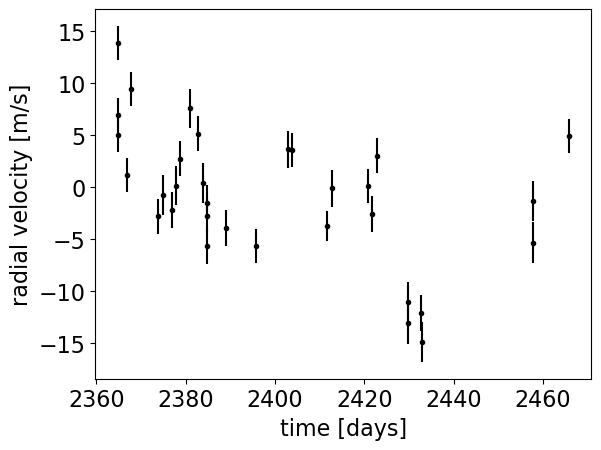

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [3]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


In [4]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([1.43643076e-05, 1.41632026e-05])

In [5]:
np.array(period_errs) / np.array(periods)

array([1.43643076e-05, 1.41632026e-05])

## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3.
First, we'll define our priors on the parameters:

In [6]:
#import pymc3 as pm
#import pymc3_ext as pmx
#import aesara_theano_fallback.tensor as tt



import pymc as pm
import pytensor.tensor as pt  # ✅ modern backend (replaces aesara.tensor / theano.tensor)
import exoplanet as xo
import numpy as np

# Input data
t0s = np.array([0.5, 1.2], dtype=np.float64)
t0_errs = np.array([0.01, 0.02], dtype=np.float64)
periods = np.array([10.5, 23.1], dtype=np.float64)
period_errs = np.array([0.2, 0.5], dtype=np.float64)
Ks = np.array([5.3, 4.1], dtype=np.float64)

# These must be defined beforehand:
# y, yerr = observed radial velocity and its uncertainty
# x = observation times for RV
# t = grid for prediction
# x_ref = reference time (for polynomial trend)
# These should be NumPy arrays like:
# y = np.array([...])
# yerr = np.array([...])
# x = np.array([...])
# t = np.linspace(min(x), max(x), 1000)
# x_ref = np.median(x)

with pm.Model() as model:
    # Transit times
    t0 = pm.Normal("t0", mu=t0s[0], sigma=t0_errs[0])
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sigma=t0_errs[1])
    t0_combined = pm.math.stack([t0, t0_2])

    # Log-period and Keplerian period
    logP = pm.Normal("logP", mu=np.log(periods), sigma=period_errs / periods, shape=2, initval=np.log(periods))
    P = pm.Deterministic("P", pm.math.exp(logP))

    # Log semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sigma=2.0, shape=2, initval=np.log(Ks))

    # Eccentricity and argument of periastron via component vector



    global ecs_x 
    global ecs_y
    global ecs 
    global ecc
    global omega 
    
    ecs_x = pm.Normal("ecs_x", mu=0.0, sigma=0.1, shape=2, initval=0.01 * np.ones(2))
    ecs_y = pm.Normal("ecs_y", mu=0.0, sigma=0.1, shape=2, initval=0.01 * np.ones(2))
    ecs = pt.stack([ecs_x, ecs_y])  # shape = (2, 2)
    ecc = pm.Deterministic("ecc", pt.sum(ecs**2, axis=0))
    omega = pm.Deterministic("omega", pt.arctan2(ecs[1], ecs[0]))

    # Van Eylen 2019 eccentricity prior
    xo.eccentricity.vaneylen19("ecc_prior", multi=True, shape=2, fixed=True, observed=ecc)

    # Jitter & quadratic trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sigma=5.0)
    trend = pm.Normal("trend", mu=0, sigma=10.0 ** -np.arange(3)[::-1], shape=3)

    # Orbit model
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0_combined, ecc=ecc, omega=omega)

    # RV model function
    def get_rv_model(t_input, name=""):
        vrad = orbit.get_radial_velocity(t_input, K=pt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        A = np.vander(t_input - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, pt.dot(A, trend))

        return pm.Deterministic("rv_model" + name, pt.sum(vrad, axis=-1) + bkg)

    # Observed RVs
  #  rv_model = get_rv_model(x)
   # rv_model_pred = get_rv_model(t, name="_pred")


    rv_model = get_rv_model(x, name="")
    _ = get_rv_model(t, name="_pred")  # define it for posterior without storing return

    err = pt.sqrt(yerr**2 + pt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y)

Now, we can plot the initial model:

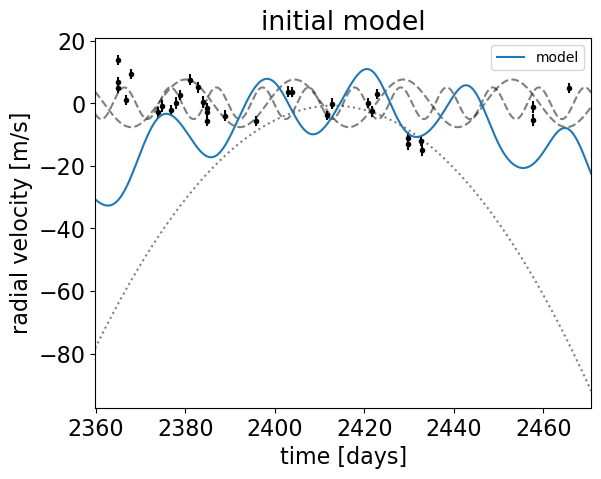

In [7]:
import matplotlib.pyplot as plt
import pymc as pm  # make sure this is imported

plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    vrad_pred_val = pm.draw(model.vrad_pred)
    bkg_pred_val = pm.draw(model.bkg_pred)
    rv_model_pred_val = pm.draw(model.rv_model_pred)

plt.plot(t, vrad_pred_val, "--k", alpha=0.5)
plt.plot(t, bkg_pred_val, ":k", alpha=0.5)
plt.plot(t, rv_model_pred_val, label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model")
plt.show()

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's fit for the maximum a posterior parameters.

In [8]:
with model:
    # First step: optimize just trend
    map_soln = pm.find_MAP(start=model.initial_point(), vars=[trend])
    
    # Step 2: add more variables
    map_soln = pm.find_MAP(start=map_soln, vars=[t0, trend, logK, logP, logs])
    
    # Step 3: add ecs
    map_soln = pm.find_MAP(start=map_soln, vars=[ecs_x, ecs_y])  # Not ecs as one block
    
    # Final full optimization
    map_soln = pm.find_MAP(start=map_soln)

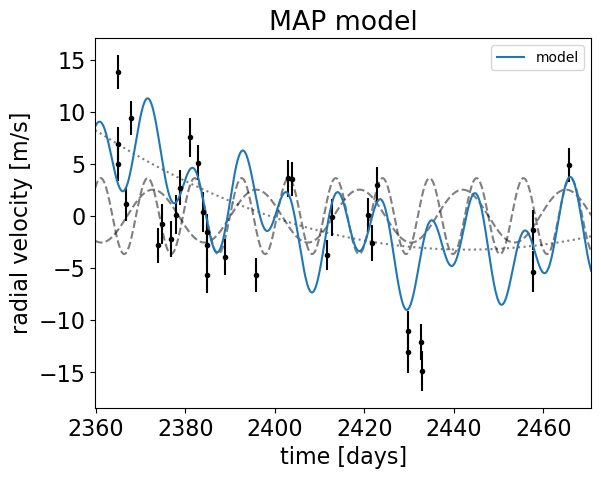

In [9]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [10]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import exoplanet as xo

# Example input data (replace with your real data)
np.random.seed(42)

# Dummy observational data (replace with actual)
x = np.linspace(0, 100, 20)
y = 5.0 * np.sin(2 * np.pi * x / 20) + np.random.normal(0, 1.0, size=len(x))
yerr = np.ones_like(y)
x_ref = np.median(x)
t = np.linspace(np.min(x), np.max(x), 1000)

# Orbital priors
t0s = np.array([0.5, 1.2], dtype=np.float64)
t0_errs = np.array([0.01, 0.02], dtype=np.float64)
periods = np.array([10.5, 23.1], dtype=np.float64)
period_errs = np.array([0.2, 0.5], dtype=np.float64)
Ks = np.array([5.3, 4.1], dtype=np.float64)

with pm.Model() as model:
    # Transit times
    t0 = pm.Normal("t0", mu=t0s[0], sigma=t0_errs[0])
    t0_2 = pm.Normal("t0_2", mu=t0s[1], sigma=t0_errs[1])
    t0_combined = pt.stack([t0, t0_2])

    # Log-period and Keplerian period
    logP = pm.Normal("logP", mu=np.log(periods), sigma=period_errs / periods, shape=2)
    P = pm.Deterministic("P", pt.exp(logP))

    # Log semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sigma=2.0, shape=2)
    K = pt.exp(logK)

    # Eccentricity components (unit disk)
    ecs_raw_x = pm.Normal("ecs_raw_x", mu=0.0, sigma=1.0, shape=2)
    ecs_raw_y = pm.Normal("ecs_raw_y", mu=0.0, sigma=1.0, shape=2)
    norm = pt.sqrt(ecs_raw_x**2 + ecs_raw_y**2)
    norm_safe = pt.maximum(norm, 1e-6)
    ecs_x_safe = 0.99 * ecs_raw_x / norm_safe
    ecs_y_safe = 0.99 * ecs_raw_y / norm_safe
    ecs_safe = pt.stack([ecs_x_safe, ecs_y_safe])
    ecc = pm.Deterministic("ecc", pt.sum(ecs_safe**2, axis=0))
    omega = pm.Deterministic("omega", pt.arctan2(ecs_safe[1], ecs_safe[0]))

    # Van Eylen 2019 eccentricity prior
    xo.eccentricity.vaneylen19("ecc_prior", multi=True, shape=2, fixed=True, observed=ecc)

    # Jitter and quadratic trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sigma=5.0)
    trend = pm.Normal("trend", mu=0, sigma=10.0 ** -np.arange(3)[::-1], shape=3)

    # Keplerian orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0_combined, ecc=ecc, omega=omega)

    # RV model function
    def get_rv_model(t_input, name=""):
        vrad = orbit.get_radial_velocity(t_input, K=K)
        pm.Deterministic(f"vrad{name}", vrad)
        A = np.vander(t_input - x_ref, 3)
        bkg = pt.dot(A, trend)
        pm.Deterministic(f"bkg{name}", bkg)
        rv_total = pt.sum(vrad, axis=-1) + bkg
        return pm.Deterministic(f"rv_model{name}", rv_total)

    # RV model: data and prediction
    rv_model = get_rv_model(x, name="")
    _ = get_rv_model(t, name="_pred")

    # Likelihood
    err = pt.sqrt(yerr**2 + pt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sigma=err, observed=y)

    # Sampling


    import pytensor

    # Disable C compilation (use Python mode)
    pytensor.config.mode = "FAST_COMPILE"
    pytensor.config.linker = "py"

    trace = pm.sample(
        tune=1000,
        draws=1000,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0, t0_2, logP, logK, ecs_raw_x, ecs_raw_y, logs, trend]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1238 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [11]:
import arviz as az


az.summary(trace)
##az.summary(
##    trace, var_names=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
###)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,0.500,0.010,0.482,0.519,0.001,0.001,89.0,244.0,1.01
t0_2,1.192,0.019,1.157,1.228,0.003,0.002,41.0,48.0,1.06
logP[0],2.355,0.018,2.318,2.388,0.002,0.002,57.0,155.0,1.04
logP[1],3.137,0.023,3.088,3.180,0.005,0.004,18.0,30.0,1.06
logK[0],0.480,1.380,-2.063,3.135,0.173,0.123,65.0,88.0,1.05
...,...,...,...,...,...,...,...,...,...
rv_model_pred[995],-2.706,2.693,-7.028,1.879,0.497,0.355,20.0,175.0,1.11
rv_model_pred[996],-2.728,2.390,-7.054,1.840,0.537,0.385,19.0,174.0,1.11
rv_model_pred[997],-2.690,3.039,-7.019,1.967,0.479,0.341,19.0,175.0,1.10
rv_model_pred[998],-2.739,2.377,-7.117,1.862,0.568,0.409,17.0,167.0,1.11


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

['t0', 't0_2', 'logP', 'logK', 'ecs_raw_x', 'ecs_raw_y', 'logs', 'trend', 'P', 'ecc', 'omega', 'vrad', 'bkg', 'rv_model', 'vrad_pred', 'bkg_pred', 'rv_model_pred']


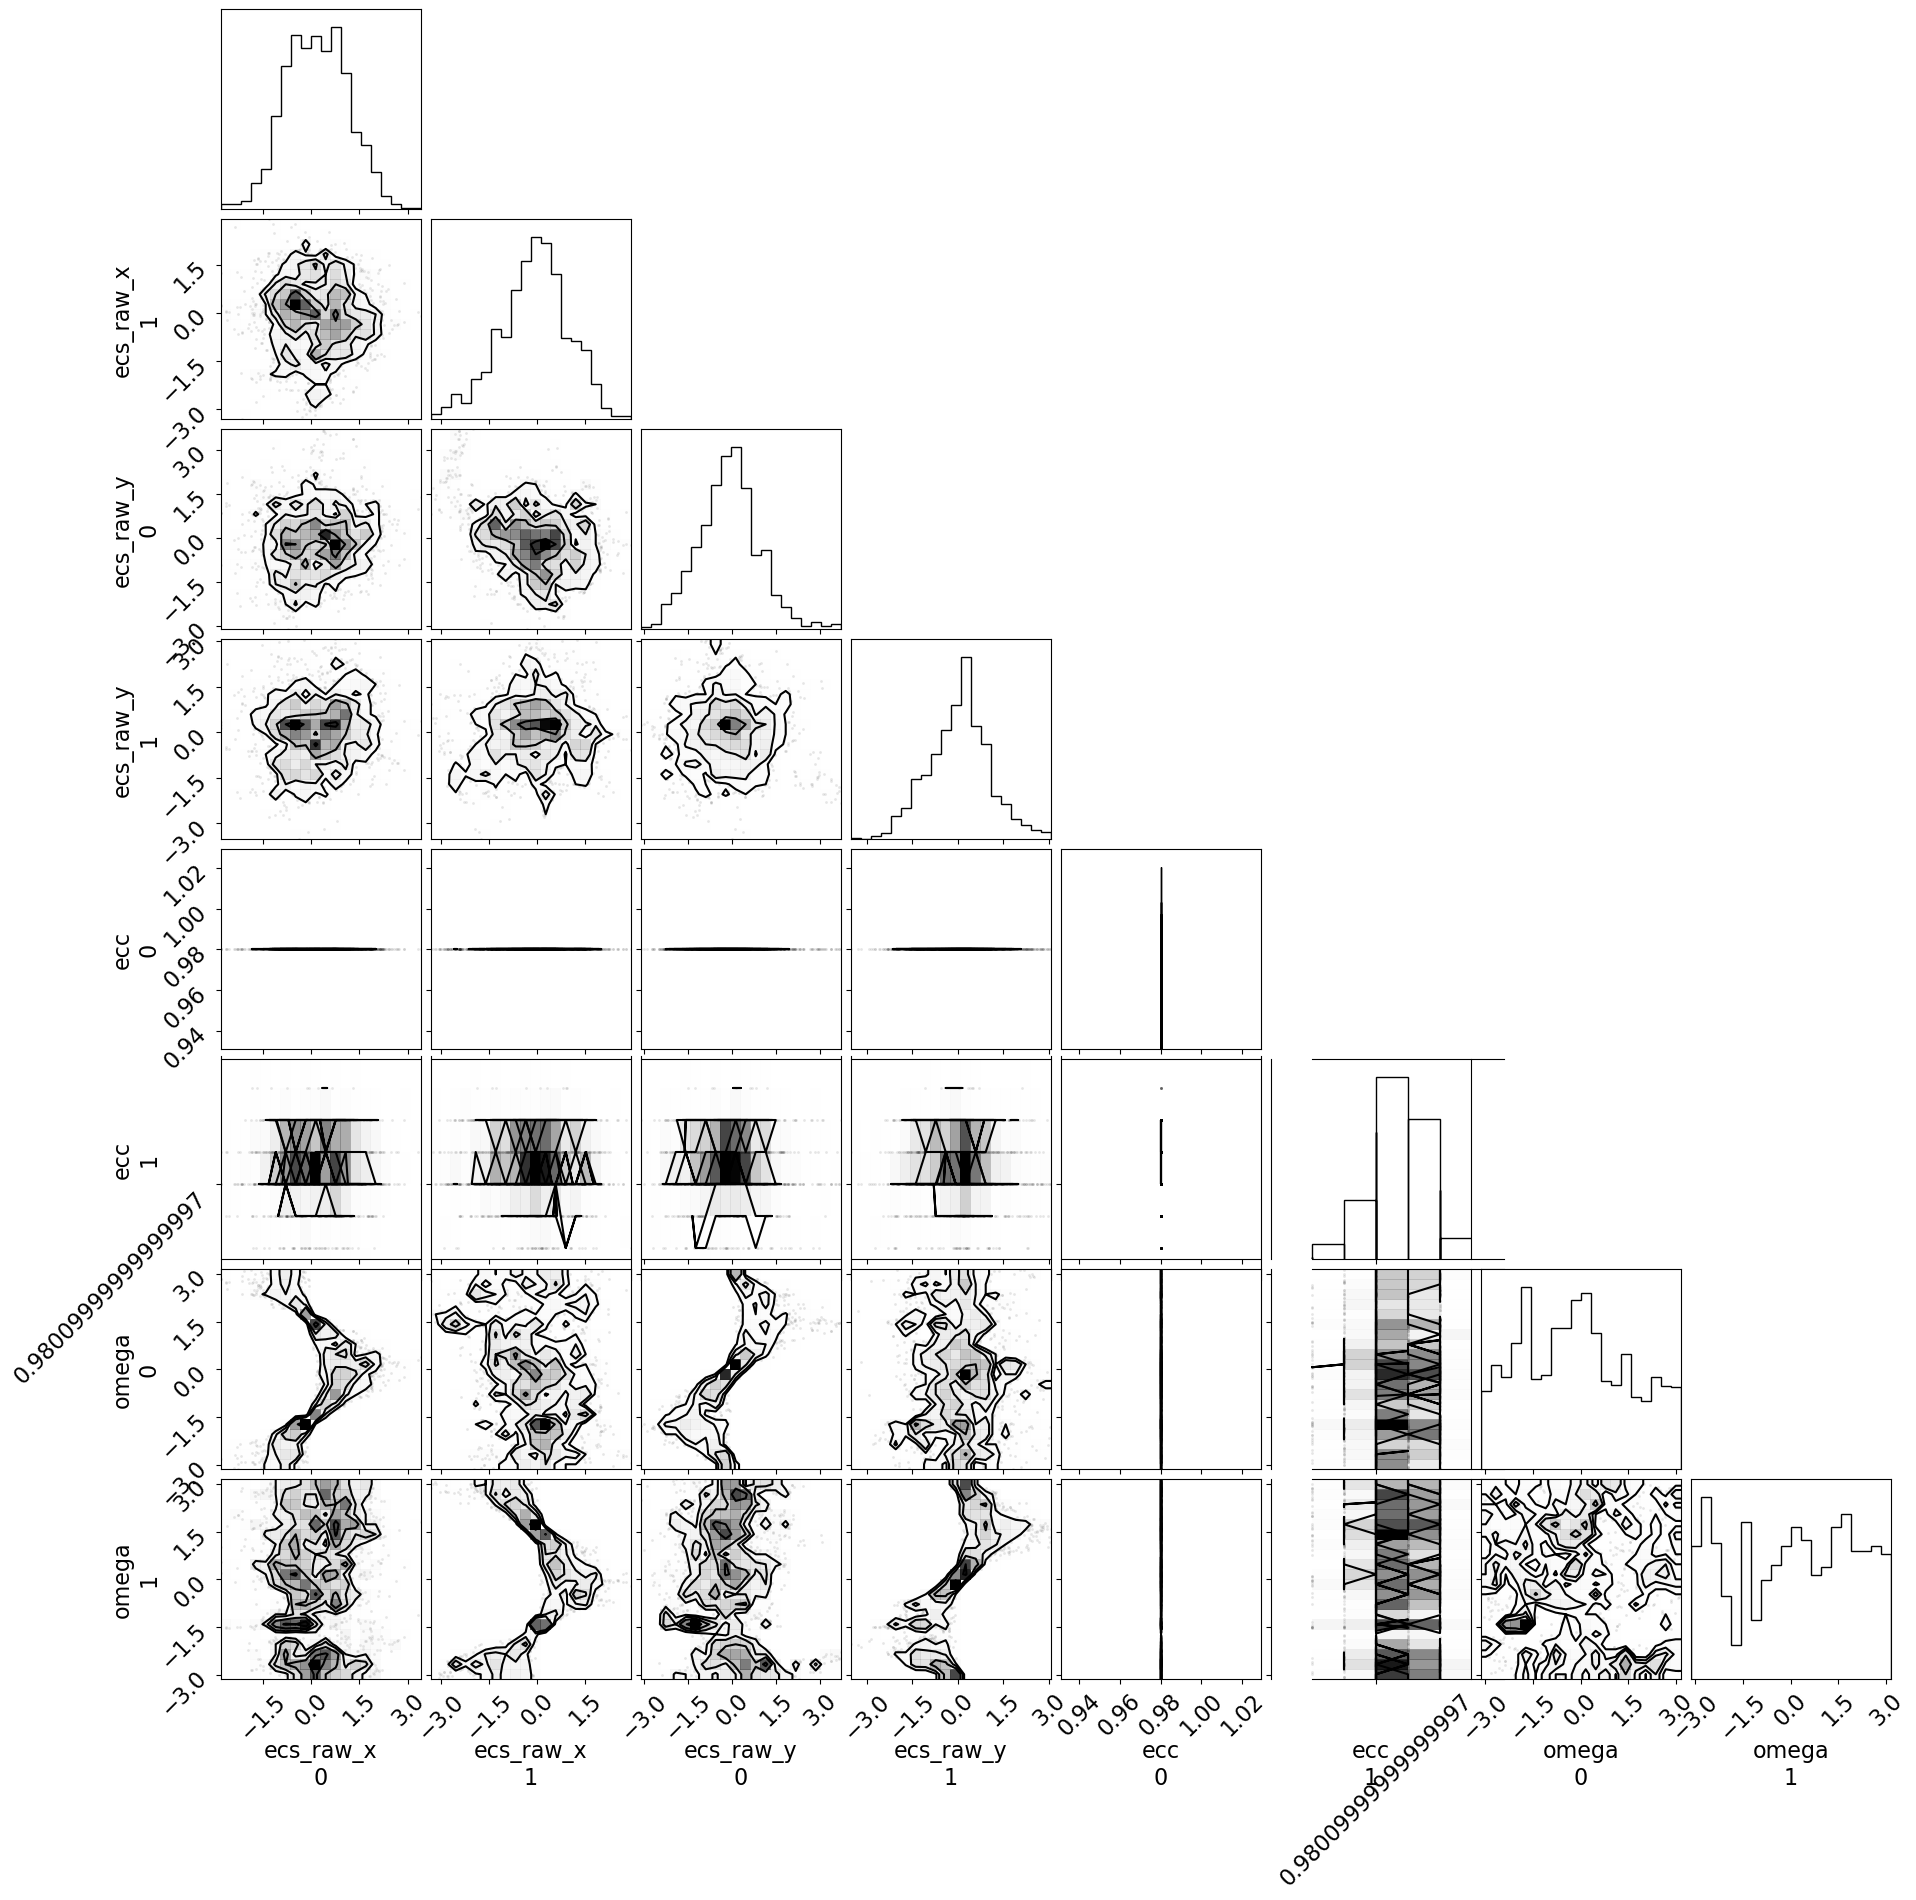

In [12]:
import sys
!{sys.executable} -m pip install corner

import corner

print(list(trace.posterior.data_vars))

with model:
    
     _ = corner.corner(trace, var_names=['ecs_raw_x', 'ecs_raw_y', 'ecc', 'omega'])
 ###   _ = corner.corner(trace, var_names=["ecc_final", "omega_final", "logK_final"])

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

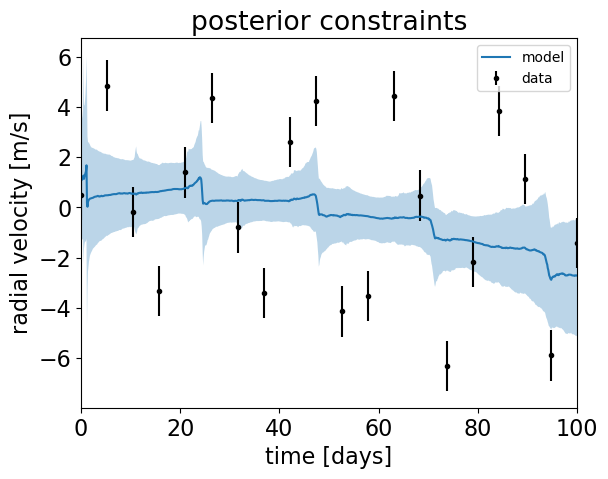

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Plot observed data with error bars
plt.errorbar(x, y, yerr=yerr, fmt=".k", label="data")

# Extract posterior predictions for RV model
rv_pred = trace.posterior["rv_model_pred"].values  # shape: (chains, draws, time)

# Compute 16th, 50th (median), and 84th percentiles
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))

# Plot the median prediction
plt.plot(t, pred[1], color="C0", label="model")

# Fill between the 16th and 84th percentile
plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3, edgecolor="none")

# Final plot formatting
plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints")
plt.show()

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

IndexError: index 1 is out of bounds for axis 2 with size 1

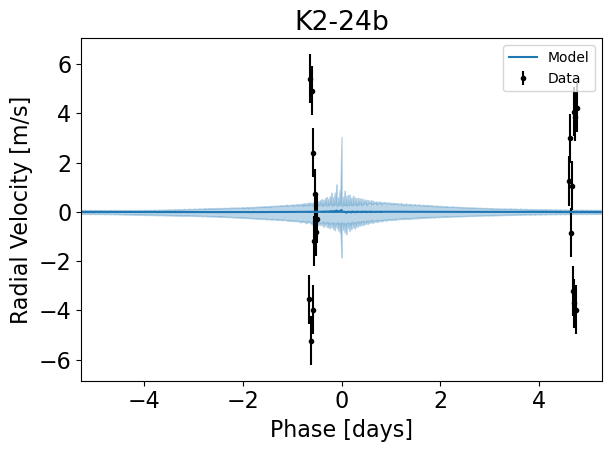

<Figure size 640x480 with 0 Axes>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Fetch posterior samples
P_post = trace.posterior["P"].values
t0_post = trace.posterior["t0"].values
vrad_post = trace.posterior["vrad"].values
bkg_post = trace.posterior["bkg"].values
vrad_pred_post = trace.posterior["vrad_pred"].values

# Ensure 3D shape (chains, draws, planets)
if P_post.ndim == 2:
    P_post = P_post[:, :, None]
if t0_post.ndim == 2:
    t0_post = t0_post[:, :, None]

n_planets = P_post.shape[-1]
letters = "bcdefgh"[:n_planets]  # label each planet with a letter

for n in range(n_planets):
    letter = letters[n]
    plt.figure()

    # Median orbital parameters
    p = np.median(P_post[:, :, n])
    t0 = np.median(t0_post[:, :, n])

    # RV contribution from other planets
    if n_planets > 1:
        other_indices = [i for i in range(n_planets) if i != n]
        other_vrad = np.sum(
            np.median(vrad_post[:, :, :, other_indices], axis=(0, 1)), axis=-1
        )
    else:
        other_vrad = 0.0

    bkg = np.median(bkg_post, axis=(0, 1))
    other = other_vrad + bkg

    # Folded observed RVs
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="Data")

    # Folded model prediction
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)

    pred = np.percentile(vrad_pred_post[:, :, inds, n], [16, 50, 84], axis=(0, 1))
    plt.plot(t_fold[inds], pred[1], color="C0", label="Model")
    plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)

    # Final plot formatting
    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Phase [days]")
    plt.ylabel("Radial Velocity [m/s]")
    plt.title(f"K2-24{letter}")
    plt.tight_layout()

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

In [ ]:
print(bib.split("\n\n")[0] + "\n\n...")